In [55]:
import pandas as pd
import csv
import re
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB

# Song Lyric Classification
[Dataset](https://www.kaggle.com/datasets/carlosgdcj/genius-song-lyrics-with-language-information/data)

In [2]:
song_lyrics = pd.read_csv('song_lyrics.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'song_lyrics.csv'

In [ ]:
song_lyrics.head()

In [4]:
song_lyrics['tag'].value_counts()

tag
pop        2138587
rap        1724816
rock        793220
rb          196462
misc        181455
country     100316
Name: count, dtype: int64

In [5]:
# Removing songs that are not in english
eng_song_lyrics = song_lyrics[song_lyrics['language'] == 'en']
eng_song_lyrics.head()

,title,tag,artist,year,views,features,lyrics,id,language_cld3,language_ft,language
0,Killa Cam,rap,Cam'ron,2004,173166,"{""Cam\\'ron"",""Opera Steve""}","[Chorus: Opera Steve & Cam'ron]\nKilla Cam, Ki...",1,en,en,en
1,Can I Live,rap,JAY-Z,1996,468624,{},"[Produced by Irv Gotti]\n\n[Intro]\nYeah, hah,...",3,en,en,en
2,Forgive Me Father,rap,Fabolous,2003,4743,{},Maybe cause I'm eatin\nAnd these bastards fien...,4,en,en,en
3,Down and Out,rap,Cam'ron,2004,144404,"{""Cam\\'ron"",""Kanye West"",""Syleena Johnson""}",[Produced by Kanye West and Brian Miller]\n\n[...,5,en,en,en
4,Fly In,rap,Lil Wayne,2005,78271,{},"[Intro]\nSo they ask me\n""Young boy\nWhat you ...",6,en,en,en


In [6]:
# Creating sample dataset with 10000 random songs
sample = eng_song_lyrics.sample(10000, random_state=0)
sample.to_csv('sample_song_lyrics.csv', sep=',')

## Splitting data into training, testing, and development sets

In [2]:
df = pd.read_csv('sample_song_lyrics.csv')

In [3]:
X_train, X_test, y_train, y_test = train_test_split(df['lyrics'], df['tag'], test_size=0.2,random_state=0)

In [4]:
# create dev set 
X_train, X_dev, y_train, y_dev = train_test_split(X_train, y_train, test_size=0.2,random_state=0)

In [5]:
train = pd.merge(X_train, y_train, left_index=True, right_index=True)
dev = pd.merge(X_dev, y_dev, left_index=True, right_index=True)
test = pd.merge(X_test, y_test, left_index=True, right_index=True)

In [6]:
# writing the datasets to csv files
train.to_csv('sample_training.csv', sep=',')
dev.to_csv('sample_dev_full.csv', sep=',')
test.to_csv('sample_test_full.csv', sep=',')
X_dev.to_csv('sample_dev_test.csv', sep=',')
X_test.to_csv('sample_test.csv', sep=',')

## Baseline System: TFIDF with cosine similarity
1. Create vectors for the 6 tags
2. Create vectors of training set input

In [7]:
categories = ['pop','rap','rock','rb','misc','country']

In [8]:
# preparing song lyrics: removing stopwords, punctuation, etc
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer 
from nltk.stem import WordNetLemmatizer 

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
# list of descriptors found within lyrics (we can add more if they come up)
stop_words = stop_words.union({'intro', 'x', 'chorus', 'chorusx', 'verse one', 'verse', 'pre', 'post', 'pre-chorus', 'prechorus', 'verse two', 'post-chorus', 'one', 'two', 'postchorus'})

tk = WhitespaceTokenizer()
lem = WordNetLemmatizer()

[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:997)>


In [9]:
def clean_lyrics(lyrics):
    clean = lyrics.strip().replace('\n', ' ').replace('[', '').replace(']', '').replace('(', '').replace(')', '')
    clean = tk.tokenize(clean)
    clean = [re.sub(r'[^\w\s]', '', token) for token in clean if re.sub(r'[^\w\s]', '', token)] # remove punctuation
    clean = [re.sub(r'\d+', '', token) for token in clean if re.sub(r'\d+', '', token)] # remove numbers
    clean = [w for w in clean if not w.lower() in stop_words] # remove stopwords
    clean = [lem.lemmatize(w) for w in clean]
    return clean

In [10]:
# clean and tokenize X_train
X_train_cl = pd.Series([clean_lyrics(x) for x in X_train])
X_dev_cl = pd.Series([clean_lyrics(x) for x in X_dev])
X_test_cl = pd.Series([clean_lyrics(x) for x in X_test])

In [11]:
# creating tfidf vectors of training set
vectorizer = TfidfVectorizer(tokenizer=lambda x: x, preprocessor=lambda x: x) #overwriting the tokenization and preprocessing step since done above
X_train_vectors = vectorizer.fit_transform(X_train_cl) # creating tfidf vectors of training set

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


## Training a model to predict genres 
1. With the tfidf vectors we can use logistic regression as our baseline model and train on the x vector set 
2. Run the regression on the development set and test set after

In [12]:
reg = LogisticRegression()
reg.fit(X_train_vectors, y_train)

LogisticRegression()

In [13]:
# running model on development set
X_dev_vectors = vectorizer.transform(X_dev_cl)
y_dev_pred = reg.predict(X_dev_vectors)

Logistic Regression doesnt support incremental learning so having a development set doesn't make a lot of sense in this situation, but it will be helpful for other models

In [14]:
# running model on test set
X_test_vectors = vectorizer.transform(X_test_cl)
y_test_pred = reg.predict(X_test_vectors)

## Evaluation

Compute the following metrics: 

- accuracy
- precision
- recall
- f-score

In [15]:
def evaluate_model(prediction, result):
    accuracy = accuracy_score(result, prediction)
    precision = precision_score(result, prediction, average='micro')
    recall = recall_score(result, prediction, average='micro')
    f1 = f1_score(result, prediction, average='micro')

    return f'Evaluation Results \n accuracy: {accuracy}\n precision: {precision}\n recall: {recall}\n f score: {f1}'

In [16]:
print(evaluate_model(y_dev_pred, y_dev))

Evaluation Results 
 accuracy: 0.608125
 precision: 0.608125
 recall: 0.608125
 f score: 0.608125


In [17]:
print(evaluate_model(y_test_pred, y_test))

Evaluation Results 
 accuracy: 0.626
 precision: 0.626
 recall: 0.626
 f score: 0.626


(2000, 6)


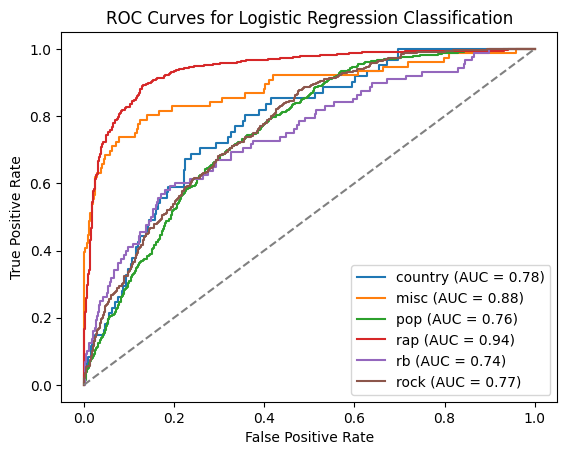

In [33]:
y_test_bin = label_binarize(y_test, classes=reg.classes_)
y_pred_proba = reg.predict_proba(X_test_vectors)

for i in range(len(reg.classes_)):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    auc_score = roc_auc_score(y_test_bin[:, i], y_pred_proba[:, i])
    plt.plot(fpr, tpr, label=f"{reg.classes_[i]} (AUC = {auc_score:.2f})")

plt.plot([0, 1], [0, 1], '--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Logistic Regression Classification")
plt.legend()
plt.show()

In [18]:
# transformer

## Training Model using k-Nearest Neighbors
1. Determine best hyperparameters
2. Train kNN classifier with those hyperparameters

In [19]:
error = list() 

for i in range(1, 30): 
    knn = KNeighborsClassifier(n_neighbors=i, metric='cosine')
    knn.fit(X_train_vectors, y_train)
    pred_i = knn.predict(X_dev_vectors)
    error.append(np.mean(pred_i != y_dev)) 

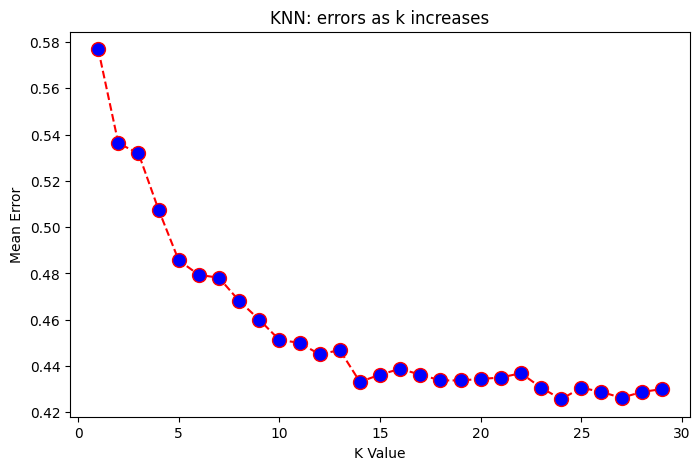

In [20]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(error)+1), error, color='red', linestyle='dashed', marker='o', markerfacecolor='blue', markersize=10)
plt.title('KNN: errors as k increases')
plt.xlabel('K Value')
plt.ylabel('Mean Error')
plt.show()

In [21]:
knn = KNeighborsClassifier(n_neighbors=14, metric='cosine')
knn.fit(X_train_vectors, y_train)

KNeighborsClassifier(metric='cosine', n_neighbors=14)

### Evaluation

In [22]:
# Evaluate on dev set
y_dev_pred = knn.predict(X_dev_vectors)
print(evaluate_model(y_dev_pred, y_dev))
print()
# Evaluate on test set
y_test_pred = knn.predict(X_test_vectors)
print(evaluate_model(y_test_pred, y_test))

Evaluation Results 
 accuracy: 0.566875
 precision: 0.566875
 recall: 0.566875
 f score: 0.566875

Evaluation Results 
 accuracy: 0.568
 precision: 0.568
 recall: 0.568
 f score: 0.568


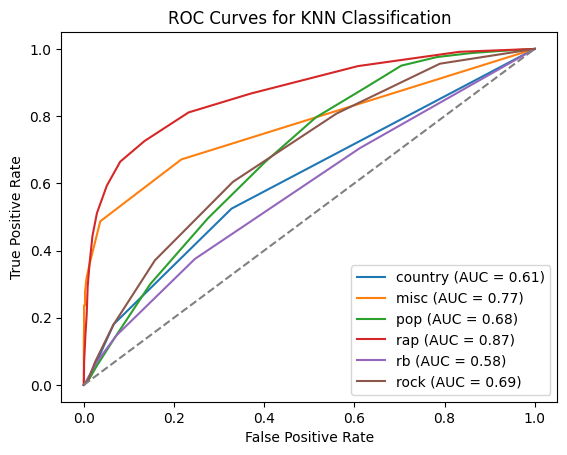

In [37]:
y_test_bin = label_binarize(y_test, classes=knn.classes_)
y_pred_proba = knn.predict_proba(X_test_vectors)

for i in range(len(knn.classes_)):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    auc_score = roc_auc_score(y_test_bin[:, i], y_pred_proba[:, i])
    plt.plot(fpr, tpr, label=f"{knn.classes_[i]} (AUC = {auc_score:.2f})")

plt.plot([0, 1], [0, 1], '--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for KNN Classification")
plt.legend()
plt.show()

## Training Model using SVM
1. Determine best hyperparameters
2. Train SVM classifier with those hyperparameters

In [43]:
C_values = np.logspace(-3, 2, 20)
errors = []

for C in C_values:
    svm = LinearSVC(C=C, max_iter=10000)
    svm.fit(X_train_vectors, y_train)
    pred = svm.predict(X_dev_vectors)
    errors.append(np.mean(pred != y_dev))

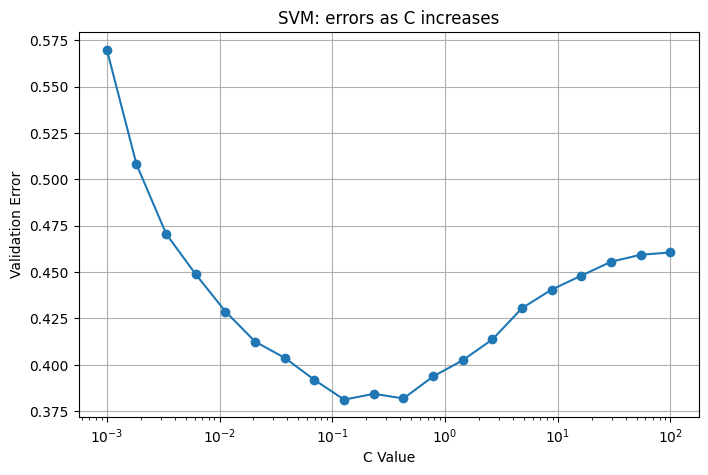

In [44]:
plt.figure(figsize=(8, 5))
plt.semilogx(C_values, errors, marker='o')
plt.xlabel('C Value')
plt.ylabel('Validation Error')
plt.title('SVM: errors as C increases')
plt.grid(True)
plt.show()

In [51]:
svm = LinearSVC(C=C_values[np.argmin(errors)])
svm = CalibratedClassifierCV(svm) 
svm.fit(X_train_vectors, y_train)

CalibratedClassifierCV(estimator=LinearSVC(C=np.float64(0.12742749857031335)))

### Evaluation

In [52]:
#Evaluate on dev set
y_dev_pred = svm.predict(X_dev_vectors)
print(evaluate_model(y_dev_pred, y_dev))
print()
# Evaluate on test set
y_test_pred = svm.predict(X_test_vectors)
print(evaluate_model(y_test_pred, y_test))


Evaluation Results 
 accuracy: 0.618125
 precision: 0.618125
 recall: 0.618125
 f score: 0.618125

Evaluation Results 
 accuracy: 0.6315
 precision: 0.6315
 recall: 0.6315
 f score: 0.6315


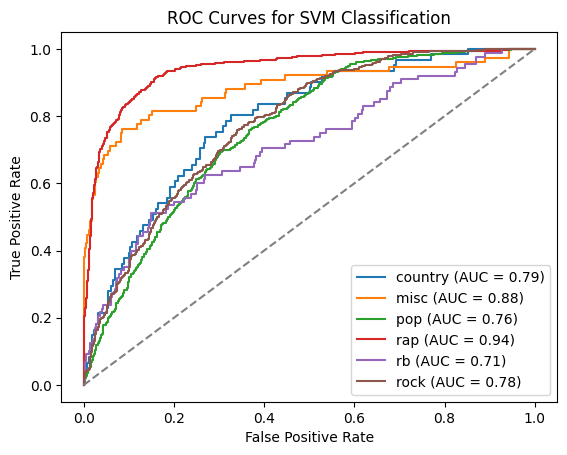

In [54]:
y_test_bin = label_binarize(y_test, classes=svm.classes_)
y_pred_proba = svm.predict_proba(X_test_vectors)

for i in range(len(svm.classes_)):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    auc_score = roc_auc_score(y_test_bin[:, i], y_pred_proba[:, i])
    plt.plot(fpr, tpr, label=f"{svm.classes_[i]} (AUC = {auc_score:.2f})")

plt.plot([0, 1], [0, 1], '--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for SVM Classification")
plt.legend()
plt.show()

## Training Model using Multinomial Naive Bayes
1. Determine best hyperparameters
2. Train kNN classifier with those hyperparameters

In [57]:
nb = MultinomialNB()
nb.fit(X_train_vectors, y_train)

y_dev_pred = nb.predict(X_dev_vectors)
print(evaluate_model(y_dev_pred, y_dev))

y_test_pred = nb.predict(X_test_vectors)
print(evaluate_model(y_test_pred, y_test))

Evaluation Results 
 accuracy: 0.58
 precision: 0.58
 recall: 0.58
 f score: 0.58
Evaluation Results 
 accuracy: 0.6095
 precision: 0.6095
 recall: 0.6095
 f score: 0.6095


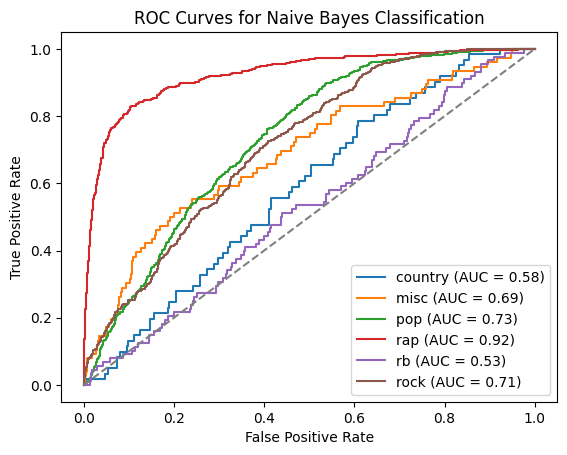

In [58]:
y_test_bin = label_binarize(y_test, classes=nb.classes_)
y_pred_proba = nb.predict_proba(X_test_vectors)

for i in range(len(nb.classes_)):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    auc_score = roc_auc_score(y_test_bin[:, i], y_pred_proba[:, i])
    plt.plot(fpr, tpr, label=f"{nb.classes_[i]} (AUC = {auc_score:.2f})")

plt.plot([0, 1], [0, 1], '--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Naive Bayes Classification")
plt.legend()
plt.show()

## Training Model using DistilBERT transformer

In [ ]:
import pandas as pd
import torch
import numpy as np
import os
import re
import random
import nltk
from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from datasets import Dataset, DatasetDict
from transformers import (
    DistilBertForSequenceClassification, 
    DistilBertTokenizerFast,
    TrainingArguments, 
    Trainer,
    EarlyStoppingCallback,
    get_linear_schedule_with_warmup,
    get_cosine_schedule_with_warmup
)
from transformers.trainer_callback import TrainerCallback
import torch.nn as nn
from torch.utils.data import WeightedRandomSampler

# Download NLTK resources if needed
try:
    nltk.data.find('tokenizers/punkt')
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('punkt')
    nltk.download('stopwords')

# Configurations
MODEL_NAME = "distilbert-base-uncased"
NUM_LABELS = 6
TEXT_COLUMN = 'lyrics'
LABEL_COLUMN = 'tag'
MAX_LENGTH = 384  # Optimized length for song lyrics
OUTPUT_DIR = './results/improved_model'
LOGGING_DIR = './logs/improved_model'
SEED = 42
NUM_EPOCHS = 6
BATCH_SIZE = 24
LEARNING_RATE = 5e-5
WARMUP_RATIO = 0.1
WEIGHT_DECAY = 0.01
GRADIENT_ACCUMULATION_STEPS = 2

# Set random seeds for reproducibility
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(SEED)

# Create directories
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(LOGGING_DIR, exist_ok=True)

# Load datasets
try:
    train_df = pd.read_csv('sample_training.csv')
    dev_df = pd.read_csv('sample_dev_full.csv')
    test_df = pd.read_csv('sample_test_full.csv')
    print(f"Train samples: {len(train_df)}, Dev samples: {len(dev_df)}, Test samples: {len(test_df)}")
except FileNotFoundError as e:
    print(f"Error: {e}")
    print("Please ensure the CSV files are in the same directory.")
    raise

# Advanced Text Preprocessing
def clean_lyrics(text):
    if not isinstance(text, str):
        return ""
    
    # Remove [Verse], [Chorus], etc.
    text = re.sub(r'\[(.*?)\]', ' ', text)
    
    # Remove line indicators like '\n' and special characters
    text = re.sub(r'\\n|\\r', ' ', text)
    
    # Remove extra whitespace and punctuation normalization
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'[^\w\s]', ' ', text)
    
    # Convert to lowercase
    text = text.lower().strip()
    
    return text

# Data Augmentation for Lyrics
def augment_lyrics(text, prob=0.3):
    if random.random() > prob:
        return text
    
    augmentation_type = random.choice(['synonym_replace', 'word_dropout', 'word_swap'])
    words = text.split()
    
    if len(words) < 5:  # Skip short texts
        return text
    
    if augmentation_type == 'word_dropout':
        # Randomly drop 10-20% of words
        dropout_ratio = random.uniform(0.1, 0.2)
        num_to_drop = max(1, int(len(words) * dropout_ratio))
        drop_indices = random.sample(range(len(words)), num_to_drop)
        return ' '.join([w for i, w in enumerate(words) if i not in drop_indices])
    
    elif augmentation_type == 'word_swap':
        # Swap adjacent words in 2-4 positions
        num_swaps = min(random.randint(2, 4), len(words) // 2)
        for _ in range(num_swaps):
            idx = random.randint(0, len(words) - 2)
            words[idx], words[idx + 1] = words[idx + 1], words[idx]
        return ' '.join(words)
    
    # Default: return original text
    return text

# Preprocessing with Advanced Cleaning and Data Augmentation
print("Preprocessing data...")
train_df['lyrics_cleaned'] = train_df[TEXT_COLUMN].apply(clean_lyrics)
dev_df['lyrics_cleaned'] = dev_df[TEXT_COLUMN].apply(clean_lyrics)
test_df['lyrics_cleaned'] = test_df[TEXT_COLUMN].apply(clean_lyrics)

# Apply data augmentation only to training data
train_df['lyrics_augmented'] = train_df['lyrics_cleaned'].apply(augment_lyrics)

# Display genre distribution
print("Genre distribution in training data:")
print(train_df[LABEL_COLUMN].value_counts())

# Handle class imbalance using weighted sampling
label_encoder = LabelEncoder()
all_labels = pd.concat([train_df[LABEL_COLUMN], dev_df[LABEL_COLUMN], test_df[LABEL_COLUMN]], ignore_index=True).unique()
label_encoder.fit(all_labels)

train_df['label_encoded'] = label_encoder.transform(train_df[LABEL_COLUMN])
dev_df['label_encoded'] = label_encoder.transform(dev_df[LABEL_COLUMN])
test_df['label_encoded'] = label_encoder.transform(test_df[LABEL_COLUMN])

# Calculate class weights for weighted loss
class_counts = train_df['label_encoded'].value_counts().sort_index()
class_weights = 1.0 / torch.tensor(class_counts.values, dtype=torch.float)
class_weights = class_weights / class_weights.sum()
class_weights = class_weights.numpy()

id2label = {i: label for i, label in enumerate(label_encoder.classes_)}
label2id = {label: i for i, label in id2label.items()}

# Create features for lexical richness and song structure
def extract_lyric_features(text):
    if not isinstance(text, str) or len(text) == 0:
        return {
            'word_count': 0,
            'unique_ratio': 0,
            'avg_word_len': 0,
            'has_verse': 0,
            'has_chorus': 0
        }
    
    words = text.lower().split()
    unique_words = set(words)
    
    features = {
        'word_count': len(words),
        'unique_ratio': len(unique_words) / max(1, len(words)),
        'avg_word_len': sum(len(w) for w in words) / max(1, len(words)),
        'has_verse': 1 if 'verse' in text.lower() else 0,
        'has_chorus': 1 if 'chorus' in text.lower() else 0
    }
    
    return features

# Add features to dataframes
for df in [train_df, dev_df, test_df]:
    feature_dicts = df[TEXT_COLUMN].apply(extract_lyric_features)
    for feature_name in ['word_count', 'unique_ratio', 'avg_word_len', 'has_verse', 'has_chorus']:
        df[feature_name] = feature_dicts.apply(lambda x: x[feature_name])

# Create datasets
train_dataset = Dataset.from_pandas(train_df[['lyrics_augmented', 'label_encoded'] + 
                                            ['word_count', 'unique_ratio', 'avg_word_len', 'has_verse', 'has_chorus']]
                                   .rename(columns={'label_encoded': 'label', 'lyrics_augmented': TEXT_COLUMN}))
dev_dataset = Dataset.from_pandas(dev_df[['lyrics_cleaned', 'label_encoded'] + 
                                       ['word_count', 'unique_ratio', 'avg_word_len', 'has_verse', 'has_chorus']]
                                 .rename(columns={'label_encoded': 'label', 'lyrics_cleaned': TEXT_COLUMN}))
test_dataset = Dataset.from_pandas(test_df[['lyrics_cleaned', 'label_encoded'] + 
                                         ['word_count', 'unique_ratio', 'avg_word_len', 'has_verse', 'has_chorus']]
                                  .rename(columns={'label_encoded': 'label', 'lyrics_cleaned': TEXT_COLUMN}))

dataset = DatasetDict({
    'train': train_dataset,
    'validation': dev_dataset,
    'test': test_dataset
})

# Tokenization with stride to handle longer texts
tokenizer = DistilBertTokenizerFast.from_pretrained(MODEL_NAME)

def tokenize_function(examples):
    return tokenizer(
        examples[TEXT_COLUMN],
        truncation=True,
        padding="max_length",
        max_length=MAX_LENGTH,
        stride=128,
        return_overflowing_tokens=False,
    )

tokenized_datasets = dataset.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.remove_columns([TEXT_COLUMN])
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")
tokenized_datasets.set_format("torch")

# Custom Model with additional features
class EnhancedDistilBertForClassification(nn.Module):
    def __init__(self, num_labels, id2label, label2id):
        super(EnhancedDistilBertForClassification, self).__init__()
        self.num_labels = num_labels
        self.id2label = id2label
        self.label2id = label2id
        
        # Load pre-trained DistilBERT
        self.distilbert = DistilBertForSequenceClassification.from_pretrained(
            MODEL_NAME,
            num_labels=num_labels,
            id2label=id2label,
            label2id=label2id
        )
        
        # Get BERT embedding size
        self.bert_hidden_size = self.distilbert.config.hidden_size
        
        # Feature processing layers
        self.feature_layer = nn.Sequential(
            nn.Linear(5, 32),  # 5 features to 32
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        
        # Replace classification head
        self.classifier = nn.Sequential(
            nn.Linear(self.bert_hidden_size + 32, 512),  # Combine BERT and features
            nn.LayerNorm(512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_labels)
        )
        
        # Remove original classifier to avoid errors
        del self.distilbert.classifier
    
    def forward(self, input_ids=None, attention_mask=None, labels=None, **kwargs):
        # Extract additional features
        features = torch.stack([
            kwargs.get('word_count', torch.zeros(input_ids.shape[0])),
            kwargs.get('unique_ratio', torch.zeros(input_ids.shape[0])),
            kwargs.get('avg_word_len', torch.zeros(input_ids.shape[0])),
            kwargs.get('has_verse', torch.zeros(input_ids.shape[0])),
            kwargs.get('has_chorus', torch.zeros(input_ids.shape[0]))
        ], dim=1).float()
        
        # Get DistilBERT outputs
        distilbert_output = self.distilbert.distilbert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        
        # Get CLS token embedding
        hidden_state = distilbert_output[0]  # [batch_size, seq_len, hidden_size]
        pooled_output = hidden_state[:, 0]  # [batch_size, hidden_size]
        
        # Process features
        processed_features = self.feature_layer(features)
        
        # Concatenate BERT embeddings with processed features
        combined = torch.cat([pooled_output, processed_features], dim=1)
        
        # Classification
        logits = self.classifier(combined)
        
        # Calculate loss if labels provided
        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss(weight=torch.tensor(class_weights).to(labels.device))
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
        
        return torch.nn.functional.softmax(logits, dim=1), loss

# Initialize custom model
model = EnhancedDistilBertForClassification(
    num_labels=NUM_LABELS,
    id2label=id2label,
    label2id=label2id
)

# Custom Trainer with gradient accumulation and learning rate scheduling
class CustomTrainer(Trainer):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
    
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        outputs, loss = model(**inputs, labels=labels)
        return (loss, outputs) if return_outputs else loss

# Learning rate scheduler callback
class LearningRateSchedulerCallback(TrainerCallback):
    def __init__(self, optimizer, num_training_steps):
        self.optimizer = optimizer
        self.scheduler = get_cosine_schedule_with_warmup(
            optimizer=optimizer,
            num_warmup_steps=int(WARMUP_RATIO * num_training_steps),
            num_training_steps=num_training_steps
        )
        self.current_step = 0
    
    def on_step_end(self, args, state, control, **kwargs):
        self.scheduler.step()
        self.current_step += 1

# Evaluation metrics
def compute_metrics(pred):
    logits, labels = pred
    preds = np.argmax(logits, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    
    # Calculate per-class metrics
    conf_matrix = confusion_matrix(labels, preds)
    class_acc = conf_matrix.diagonal() / conf_matrix.sum(axis=1)
    
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall,
        'class_accuracy': {id2label[i]: float(acc_val) for i, acc_val in enumerate(class_acc)}
    }

# Training arguments
training_args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    num_train_epochs=NUM_EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE * 2,
    gradient_accumulation_steps=GRADIENT_ACCUMULATION_STEPS,
    learning_rate=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY,
    logging_dir=LOGGING_DIR,
    logging_steps=50,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    greater_is_better=True,
    fp16=True,  # Use mixed precision training
    dataloader_num_workers=4,
    group_by_length=True,  # Batch similar length sequences together
    report_to="tensorboard",
)

# Initialize trainer
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
    callbacks=[
        EarlyStoppingCallback(early_stopping_patience=2),
    ],
)

# Add learning rate scheduler
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY
)
num_training_steps = len(tokenized_datasets["train"]) * NUM_EPOCHS // (BATCH_SIZE * GRADIENT_ACCUMULATION_STEPS)
lr_scheduler_callback = LearningRateSchedulerCallback(optimizer, num_training_steps)
trainer.add_callback(lr_scheduler_callback)

# Train the model
print("Starting training...")
trainer.train()
print("Training finished.")

# Evaluation
print("Evaluating on the test set...")
eval_results = trainer.evaluate(eval_dataset=tokenized_datasets["test"])
print("Test Set Evaluation Results:")
print(eval_results)

# Save the fine-tuned model and tokenizer
print("Saving model...")
trainer.save_model(f"{OUTPUT_DIR}/best_model")
tokenizer.save_pretrained(f"{OUTPUT_DIR}/best_model")
print(f"Model saved to {OUTPUT_DIR}/best_model")

# Example for inference
def predict_genre(text, model_path=f"{OUTPUT_DIR}/best_model"):
    # Load the saved model and tokenizer
    model = EnhancedDistilBertForClassification.from_pretrained(model_path)
    tokenizer = DistilBertTokenizerFast.from_pretrained(model_path)
    
    # Clean and preprocess the text
    cleaned_text = clean_lyrics(text)
    
    # Extract features
    features = extract_lyric_features(text)
    
    # Tokenize
    inputs = tokenizer(cleaned_text, return_tensors="pt", truncation=True, 
                      padding="max_length", max_length=MAX_LENGTH)
    
    # Add features
    feature_tensors = {
        k: torch.tensor([v], dtype=torch.float) 
        for k, v in features.items()
    }
    
    # Move to GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    feature_tensors = {k: v.to(device) for k, v in feature_tensors.items()}
    
    # Make prediction
    with torch.no_grad():
        outputs, _ = model(**inputs, **feature_tensors)
        predicted_class_id = torch.argmax(outputs, dim=1).item()
    
    return model.id2label[predicted_class_id]